In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dimension = 2
points = 3

In [11]:
def creerPoints(centre, rayon, nb_points=points, nb_dimensions=dimension):
    result = np.zeros((nb_points, nb_dimensions))
    for j in range(nb_dimensions):
        result[:, j] += centre[j]
    for i in range(nb_points):
        r = rayon*np.random.uniform(0, 1)
        theta = np.random.uniform(0, 2*np.pi)
        result[i, 0] += r*np.cos(theta)
        result[i, 1] += r*np.sin(theta)
    return result

def creerClusters(c1, r1, c2, r2, nb_dimensions=dimension, nb_points=points, createur=creerPoints):
    return createur(c1, r1, nb_points, nb_dimensions), createur(c2, r2, nb_points, nb_dimensions)

def trouverChemins():
    pass

def assigner():
    pass

def afficherClusters(cluster1, cluster2):
    plt.plot(cluster1[:, 0], cluster1[:, 1], 'or')
    plt.plot(cluster2[:, 0], cluster2[:, 1], 'ob')
    plt.show()

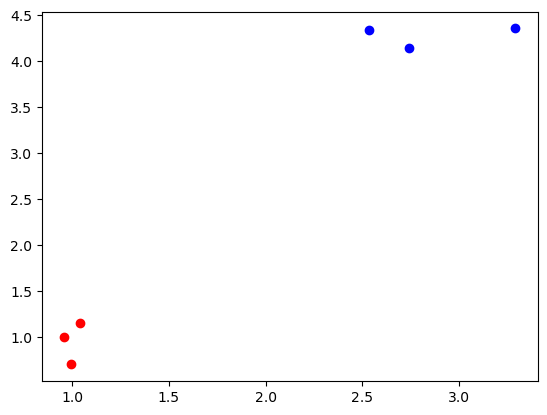

In [14]:
c1, r1 = [1, 1], 0.5
c2, r2 = [3, 4], 0.8

A, B = creerClusters(c1, r1, c2, r2)

afficherClusters(A, B)